In [2]:
from typing import Any, Optional, Callable, Tuple
import numpy as np
import matplotlib.pyplot as plt
import firedrake as fd
import os
import math
from numpy.typing import NDArray
from ufl import tanh as ufl_tanh
import time
os.environ["OMP_NUM_THREADS"] = "4"


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [3]:
def width(w0: float, w1: float, sa: float, sb: float, kk1: float, ss: float) -> float:
    """
    Simple width function with one constriction using hyperbolic tangent.
    
    Parameters:
    -----------
    w0 : baseline width (m)
    w1 : width reduction amplitude (m)
    sa, sb : start and end positions of constriction (m)
    kk1 : steepness parameter for transition (1/m)
    ss : spatial coordinate s (m)
    
    Returns:
    --------
    Width at position ss (m)
    """
    return w0-0.5*w1*(tanh(kk1*(ss-sa))*tanh(kk1*(sb-ss)))

def width2ufl(w0: float, w1: float, w2: float, sa: float, sb: float, 
              kk1: float, kk2: float, sc: float, sd: float, ss: Any) -> Any:
    """
    Extended width function with TWO constrictions for UFL expressions.
    
    This version uses UFL's tanh for compatibility with Firedrake variational forms.
    Creates two separate constrictions in the river channel.
    
    Parameters:
    -----------
    w0 : baseline width (m)
    w1, w2 : width reduction amplitudes for first and second constrictions (m)
    sa, sb : positions for first constriction (m)
    sc, sd : positions for second constriction (m)
    kk1, kk2 : steepness parameters (1/m)
    ss : spatial coordinate (m)
    
    Returns:
    --------
    UFL expression for width at position ss
    """
    return w0-0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss)))-0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))
    # Alternative formulation (commented out):
    # return w0-0.5*w1*(ufl_tanh(kk1*(ss-sa))*ufl_tanh(kk1*(sb-ss)))-0.5*w2*(ufl_tanh(kk2*(ss-sc))*ufl_tanh(kk2*(sd-ss)))


In [ ]:

"""
River object encapsulating geometry, physical parameters, and mesh.

This class represents a 1D river channel with variable width, handling:
- Channel geometry (length, width profile, constrictions)
- Physical parameters (Manning coefficient, bed slope, gravity)
- Computational mesh and function spaces
- River profile type (simple rectangular or compound channel)

Attributes:
-----------
Lx : float
    Domain length (m)
Nx : int
    Number of mesh cells
w0, w1, w2 : float
    Width parameters (baseline and constriction amplitudes)
wb, hb : float
    Narrow channel width and height for compound profile
slope : float
    Bed slope (negative for downstream flow)
Cm : float
    Manning roughness coefficient
grav : float
    Gravitational acceleration (m/s²)
profile_type : int
    River profile type (0=simple rectangular, 1=compound channel)
mesh : fd.mesh.MeshGeometry
    Firedrake mesh object
x : UFL expression
    Spatial coordinate
DG0, CG1 : fd.FunctionSpace
    Function spaces for discontinuous and continuous fields
"""
class River(object):
    
    def __init__(
        self,
        Lx: float = 5000.0,
        Nx: int = 2500,
        w0: float = 100.0,
        w1: float = 90.0,
        w2: float = 80.0,
        xa: float = 500.0,
        xb: float = 600.0,
        xc: float = 1000.0,
        xd: float = 1200.0,
        k1: float = 0.024,
        k2: float = 0.027,
        wb: float = 20.0,
        hb: float = 4.0,
        slope: float = -0.001,
        Cm: float = 0.1,
        grav: float = 9.81,
        profile_type: int = 0,
        nDG: int = 0,
        nCG: int = 4
    ):
        """
        Initialize River object with geometric and physical parameters.
        
        Parameters:
        -----------
        Lx : Domain length (m)
        Nx : Number of mesh cells
        w0, w1, w2 : Width parameters (m)
        xa, xb, xc, xd : Constriction positions (m)
        k1, k2 : Constriction steepness (1/m)
        wb, hb : Narrow channel dimensions (m) for compound profile
        slope : Bed slope (dimensionless, negative for downstream)
        Cm : Manning coefficient (dimensionless)
        grav : Gravitational acceleration (m/s²)
        profile_type : 0 for simple rectangular, 1 for compound channel
        nDG, nCG : Polynomial degrees for DG and CG spaces
        """
        # Store geometric parameters
        self.Lx: float = Lx
        self.Nx: int = Nx
        self.dxx: float = Lx / Nx
        
        # Width profile parameters
        self.w0: float = w0
        self.w1: float = w1
        self.w2: float = w2
        self.xa: float = xa
        self.xb: float = xb
        self.xc: float = xc
        self.xd: float = xd
        self.k1: float = k1
        self.k2: float = k2
        
        # Compound channel parameters
        self.wb: float = wb
        self.hb: float = hb
        self.profile_type: int = profile_type
        
        # Physical parameters
        self.slope: float = slope
        self.sqrtmslope: float = np.sqrt(-slope)
        self.Cm: float = Cm
        self.grav: float = grav
        
        # Create mesh and function spaces
        self.mesh: fd.mesh.MeshGeometry = fd.IntervalMesh(Nx, Lx)
        self.x: Any = fd.SpatialCoordinate(self.mesh)[0]
        
        # Function spaces
        self.DG0: fd.FunctionSpace = fd.FunctionSpace(self.mesh, "DG", nDG)
        self.CG1: fd.FunctionSpace = fd.FunctionSpace(self.mesh, "CG", nCG)
        
        # Facet normal
        self.n: Any = fd.FacetNormal(self.mesh)
        
    def width(self, s: Any) -> Any:
        """
        Compute river width at position s using UFL expression.
        
        Parameters:
        -----------
        s : spatial coordinate (can be UFL expression or float)
        
        Returns:
        --------
        Width at position s (UFL expression)
        """
        
        if self.profile_type == 0:
            return self.w0 + 0 * s  # Simple rectangular channel with constant width
        else:
            return width2ufl(
                self.w0, self.w1, self.w2,
                self.xa, self.xb, self.k1, self.k2,
                self.xc, self.xd, s
            )
    
    def manning_flux(self, A: Any) -> Any:
        """
        Compute Manning's equation flux F(A) for given cross-sectional area.
        
        F(A) = (√|slope|/Cm) * A^(5/3) / P^(2/3)
        
        Parameters:
        -----------
        A : Cross-sectional area (Firedrake Function or UFL expression)
        
        Returns:
        --------
        Flux F(A) as UFL expression
        """
        widL: Any = self.width(self.x)
        
        if self.profile_type == 0:
            # Simple rectangular channel: P = w + 2A/w
            return self.sqrtmslope * A**(5/3) / (widL + 2.0*A/widL)**(2/3) / self.Cm
        else:
            # Compound channel with conditional perimeter
            P_low = self.wb + 2.0*A/self.wb
            # Wetted perimeter for high flow in compound channel given by equation
            P_high = self.wb + 2*self.hb + widL - self.wb + 2.0*(A - self.hb*self.wb)/widL
            return fd.conditional(
                A < self.wb*self.hb,
                self.sqrtmslope * A**(5/3) / P_low**(2/3) / self.Cm,
                self.sqrtmslope * A**(5/3) / P_high**(2/3) / self.Cm
            )
    
    def wave_speed(self, A: Any) -> Any:
        """
        Compute characteristic wave speed dF/dA for upwind flux selection.
        
        Parameters:
        -----------
        A : Cross-sectional area
        
        Returns:
        --------
        Wave speed dF/dA (UFL expression)
        """
        widL: Any = self.width(self.x)
        
        if self.profile_type == 0:
            # Simple rectangular channel
            return (1/3) * self.sqrtmslope * A**(2/3) * (5*widL + 6*A/widL) / (widL + 2.0*A/widL)**(5/3) / self.Cm
        else:
            # Compound channel
            P_high = self.wb + 2*self.hb + widL - self.wb + 2.0*(A - self.hb*self.wb)/widL
            return (self.sqrtmslope/(3*self.Cm)) * A**(2/3) * fd.conditional(
                A < self.hb*self.wb + 0*A,
                (5*self.wb + 6*A/self.wb) / (self.wb + 2.0*A/self.wb)**(5/3),
                (5*P_high + 6*A/widL) / 
                P_high**(5/3)
            )
    
    def evaluate_width_array(self, xvals: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Evaluate width at array of x-coordinates.
        
        Parameters:
        -----------
        xvals : Array of x-coordinates
        
        Returns:
        --------
        Array of width values
        """
        wid_func: fd.Function = fd.Function(self.CG1).interpolate(self.width(self.x))
        return np.array([wid_func.at(xval) for xval in xvals])


class RiverSolver:
    """
    Solver for 1D kinematic river flow using finite volume method.
    
    This class implements the Godunov upwind scheme for solving the
    shallow water equations with Manning's equation on a River object.
    
    Features:
    - Explicit forward Euler time integration
    - Upwind Godunov flux with wave speed calculation
    - CFL condition for time step stability
    - Time-varying boundary conditions (Gaussian pulse option)
    - Automatic solution storage at specified intervals
    
    Attributes:
    -----------
    river : River
        River object containing geometry and physical parameters
    H0 : float
        Initial water depth (m)
    CFL : float
        CFL number for stability
    dt : float
        Time step (s)
    A : fd.Function
        Current cross-sectional area solution
    """
    
    def __init__(
        self,
        river: River,
        H0: float = 1.0,
        CFL: float = 0.5,
        Qmax: float = 0.0,
        tmax: float = None,
        gamfac: float = 0.000001,
        boundaryType: str = "constant",
        verbosity: int = 0,
        dt : float = None
    ):
        """
        Initialize solver for given River object.
        
        Parameters:
        -----------
        river : River object
        H0 : Initial water depth (m)
        CFL : CFL number for time step control
        Qmax : Maximum additional discharge for Gaussian pulse (m³/s)
        tmax : Time of peak inflow (s), defaults to None
        gamfac : Gaussian width parameter
        """
        self.verbosity: int = verbosity

        self.river: River = river
        self.H0: float = H0
        self.CFL: float = CFL

        # Boundary condition parameters
        self.boundaryType: str = boundaryType
        self.Qmax: float = Qmax
        self.tmax: float = tmax
        self.gamfac: float = gamfac
        
        # Compute initial time step
        c00: float = np.sqrt(river.grav * H0)
        if dt is None:
            self.dt: float = CFL * river.dxx / c00
        else:
            self.dt: float = dt
        
        # Solution variables
        self.A: fd.Function = fd.Function(river.DG0, name="A")
        self.A_new: fd.Function = fd.Function(river.DG0, name="A_new")
        
        # Boundary condition
        self.A_inflow: fd.Constant = fd.Constant(H0 * river.w0)
        self.A_inflow_value: float = H0 * river.w0
        self.F_inflow: fd.Constant = fd.Constant(0.0)
        
        # Storage for solution history
        self.time_history: list = []
        self.solution_history: list = []
        
        # Build variational formulation
        self._build_weak_form()

    def time_indices(self) -> int:
        """Return number of stored time indices."""
        return len(self.time_history)
        
    def _build_weak_form(self) -> None:
        """Build the weak formulation for the finite volume scheme"""
        river = self.river
        
        # Test and trial functions
        v: Any = fd.TestFunction(river.DG0)
        A_trial: Any = fd.TrialFunction(river.DG0)
        
        # Mass matrix
        a_mass: Any = v * A_trial * fd.dx
        
        # Average at facets
        A_avg: Any = 0.5 * (self.A('+') + self.A('-'))
        
        # Flux function
        FA: Any = river.manning_flux(self.A)
        FA_minus: Any = river.manning_flux(self.A('-'))
        FA_plus: Any = river.manning_flux(self.A('+'))
        
        # Wave speed for upwind selection
        dFdA_avg: Any = river.wave_speed(A_avg)
        dFdA_bnd: Any = river.wave_speed(self.A)
        
        # Upwind flux selection
        FA_flux: Any = fd.conditional(dFdA_avg * river.n[0]('+') > 0, FA_plus, FA_minus)
        
        # Boundary fluxes
        FA_flux_left: Any = fd.conditional((dFdA_bnd * river.n[0]) > 0, self.F_inflow + 0.0*self.A, self.F_inflow + 0.0*self.A)
        FA_flux_right: Any = fd.conditional((dFdA_bnd * river.n[0]) > 0, FA, FA)
        
        # Right-hand side: A^n - dt * (flux divergence)
        L: Any = v * self.A * fd.dx - self.dt * FA_flux * river.n[0]('+') * (v('+') - v('-')) * fd.dS
        L = L - self.dt * FA_flux_left * river.n[0] * v * fd.ds(1) - self.dt * FA_flux_right * river.n[0] * v * fd.ds(2)
        
        # Variational problem
        self.problem: fd.solving.LinearVariationalProblem = fd.LinearVariationalProblem(a_mass, L, self.A_new)
        self.solver: fd.solving.LinearVariationalSolver = fd.LinearVariationalSolver(self.problem)
        
        # Compute initial inflow flux
        widL0: Any = river.width(0)
        self.F_inflow_value: float = river.sqrtmslope * self.A_inflow_value**(5/3) / (widL0 + 2.0*self.A_inflow_value/widL0)**(2/3) / river.Cm
        self.F_inflow.assign(self.F_inflow_value)
        
    def set_initial_condition(self, A0_expr: Any = None) -> None:
        """
        Set initial condition for cross-sectional area.
        
        Parameters:
        -----------
        A0_expr : UFL expression for initial area, defaults to H0 * w(x)
        """
        if A0_expr is None:
            # Default: uniform depth H0 with variable width
            wx: Any = self.river.width(self.river.x)
            A0_expr = self.H0 * wx
        
        self.A.interpolate(A0_expr)
    
    def plot_ic(self) -> None:
        """Plot the initial condition of cross-sectional area."""
        xvals: NDArray[np.float64] = np.linspace(0, self.river.Lx, 500)
        Avals: NDArray[np.float64] = self.evaluate_solution_array(xvals, self.A)
        wVals: NDArray[np.float64] = self.river.evaluate_width_array(xvals)
        Qvals: NDArray[np.float64] = self.evaluate_discharge_array(xvals, self.A)
        
        plt.figure(figsize=(10, 4))
        plt.subplot(2, 1, 1)
        plt.plot(xvals, Avals, label='A (m²)')
        plt.title('Initial Condition: Cross-Sectional Area')
        plt.xlabel('x (m)')
        plt.ylabel('A (m²)')
        plt.ylim(0, max(Avals)*1.1)
        plt.grid()
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(xvals, wVals, label='Width (m)', color='orange')
        plt.title('River Width Profile')
        plt.xlabel('x (m)')
        plt.ylabel('Width (m)')
        plt.ylim(0, max(wVals)*1.1)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.subplot(2, 1, 1)
        plt.plot(xvals, Qvals, label='Q (m³/s)', color='green')
        plt.title('Initial Condition: Discharge')
        plt.xlabel('x (m)')
        plt.ylabel('Q (m³/s)')
        plt.ylim(0, max(Qvals)*1.1)
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

    def boundary_at_time(self, t: float) -> None:
        """
        Update inflow boundary condition with optional Gaussian pulse.
        
        Parameters:
        -----------
        t : Current time (s)
        """
        if self.boundaryType == "gaussian" and self.Qmax > 0 and self.tmax is not None:
            # Gaussian pulse: Q(t) = Q_base + Q_max * exp(-γ*(t-t_max)²)
            Q_t: float = self.F_inflow_value + self.Qmax * np.exp(-self.gamfac * (t - self.tmax)**2)
        else:
            # Constant inflow
            Q_t: float = self.F_inflow_value
        
        self.F_inflow.assign(Q_t)
        return Q_t
        
    def plot_boundary_condition(self) -> None:
        """Plot the inflow boundary condition over time."""
        print(f'Plotting boundary condition: Type={self.boundaryType}, Qmax={self.Qmax}, tmax={self.tmax}, gamfac={self.gamfac}')

        times: NDArray[np.float64] = np.linspace(0, 4*self.tmax if self.tmax else 3600, 500)
        Qvals: NDArray[np.float64] = np.array([
            self.boundary_at_time(t)
            for t in times
        ])
        print(f'Q Values at boundary: {Qvals[:10]} ...')
        
        plt.figure(figsize=(8, 4))
        plt.plot(times, Qvals, label='Inflow Q(t)')
        plt.title('Inflow Boundary Condition Over Time')
        plt.xlabel('Time (s)')
        plt.ylabel('Discharge Q (m³/s)')
        plt.grid()
        plt.legend()
        plt.show()
        
    def step(self, t: float) -> None:
        """
        Advance solution by one time step.
        
        Parameters:
        -----------
        t : Current time (s)
        """
        # Update boundary condition
        self.boundary_at_time(t)
        
        # Solve
        self.solver.solve()
        
        # Update solution
        self.A.assign(self.A_new)
        
    def solve(
        self,
        T_final: float,
        n_output: int = 16,
        verbose: bool = True
    ) -> Tuple[list, list]:
        """
        Solve from t=0 to T_final with automatic output storage.
        
        Parameters:
        -----------
        T_final : Final time (s)
        n_output : Number of output snapshots to store
        verbose : Print progress messages
        
        Returns:
        --------
        (time_history, solution_history) : Lists of times and solution snapshots
        """
        t: float = 0.0
        nt: int = 0
        dt_output: float = T_final / n_output
        t_next_output: float = 0.0
        
        # Clear history
        self.time_history = []
        self.solution_history = []
        
        # Store initial condition
        self.time_history.append(t)
        self.solution_history.append(self.A.copy(deepcopy=True))
        
        if verbose:
            print(f"Starting solver: T_final={T_final}s, dt={self.dt}s, n_steps≈{int(T_final/self.dt)}")
        
        tic: float = time.time()
        
        while t < T_final:
            # Advance time
            t += self.dt
            nt += 1
            
            # Take one step
            self.step(t)
            
            # Store output
            if t >= t_next_output:
                self.time_history.append(t)
                self.solution_history.append(self.A.copy(deepcopy=True))
                t_next_output += dt_output
                
                if verbose:
                    print(f"  t = {t:.1f}s (step {nt})")
        
        toc: float = time.time() - tic
        
        if verbose:
            print(f"Solver completed: {nt} steps in {toc/60:.2f} minutes")
        
        return self.time_history, self.solution_history
    
    def plot_solution_history(self) -> None:
        """Plot stored solution history in a 4 columns and as many rows as necessary"""
        columns = 4
        rows = math.ceil(len(self.solution_history) / columns)
        plt.figure(figsize=(4 * columns, 3 * rows))
        for i, (t, A_sol) in enumerate(zip(self.time_history, self.solution_history)):
            plt.subplot(rows, columns, i + 1)
            xvals: NDArray[np.float64] = np.linspace(0, self.river.Lx, 500)
            Avals: NDArray[np.float64] = self.evaluate_solution_array(xvals, A_sol)
            plt.plot(xvals, Avals, label=f't={t:.1f}s')
            plt.title(f'Solution at t={t:.1f}s')
            plt.xlabel('x (m)')
            plt.ylabel('A (m²)')
            plt.ylim(0, max(Avals)*1.1)
            plt.grid()
            plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_at_time(self, t_index: int) -> None:
        """
        Plot solution at specified time index from history.
        
        Parameters:
        -----------
        t_index : Index of time step to plot
        """
        if t_index < 0 or t_index >= len(self.solution_history):
            raise IndexError("t_index out of range of stored solution history.")
        
        t: float = self.time_history[t_index]
        A_sol: fd.Function = self.solution_history[t_index]
        
        xvals: NDArray[np.float64] = np.linspace(0, self.river.Lx, 500)
        Avals: NDArray[np.float64] = self.evaluate_solution_array(xvals, A_sol)
        
        plt.figure(figsize=(8, 4))
        plt.plot(xvals, Avals, label=f't={t:.1f}s')
        plt.title(f'Solution at t={t:.1f}s')
        plt.xlabel('x (m)')
        plt.ylabel('A (m²)')
        plt.ylim(0, max(Avals)*1.1)
        plt.grid()
        plt.legend()
        plt.show()    

    def compute_discharge(self, A_func: fd.Function = None) -> fd.Function:
        """
        Compute discharge Q from cross-sectional area using Manning's equation.
        
        Parameters:
        -----------
        A_func : Area function, defaults to current solution self.A
        
        Returns:
        --------
        Q : Discharge as Firedrake Function
        """
        if A_func is None:
            A_func = self.A
        
        Q: fd.Function = fd.Function(self.river.DG0, name="Q")
        Q.interpolate(self.river.manning_flux(A_func))
        return Q
    
    def evaluate_solution_array(
        self,
        xvals: NDArray[np.float64],
        A_func: fd.Function = None
    ) -> NDArray[np.float64]:
        """
        Evaluate solution at array of x-coordinates.
        
        Parameters:
        -----------
        xvals : Array of x-coordinates
        A_func : Area function to evaluate, defaults to current solution
        
        Returns:
        --------
        Array of area values
        """
        if A_func is None:
            A_func = self.A
        
        return np.array([A_func.at(xval) for xval in xvals])
    
    def evaluate_discharge_array(
        self,
        xvals: NDArray[np.float64],
        A_func: fd.Function = None
    ) -> NDArray[np.float64]:
        """
        Evaluate discharge at array of x-coordinates.
        
        Parameters:
        -----------
        xvals : Array of x-coordinates
        A_func : Area function to evaluate, defaults to current solution
        
        Returns:
        --------
        Array of discharge values
        """
        if A_func is None:
            A_func = self.A
        
        Q_func: fd.Function = self.compute_discharge(A_func)
        return np.array([Q_func.at(xval) for xval in xvals])


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` clas

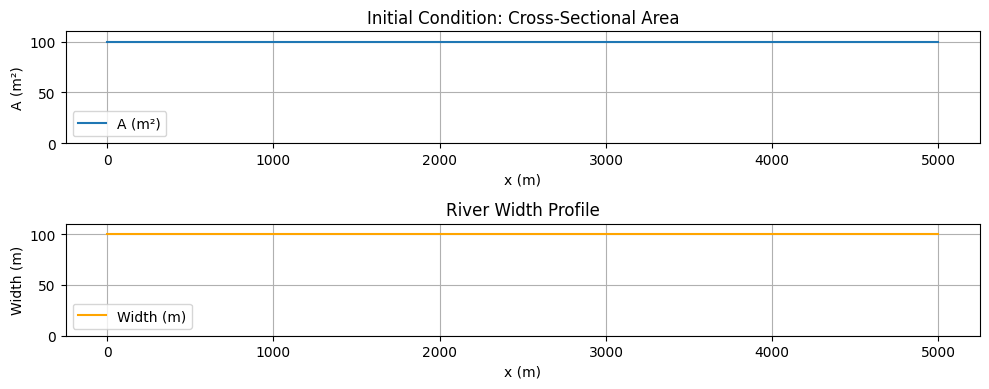

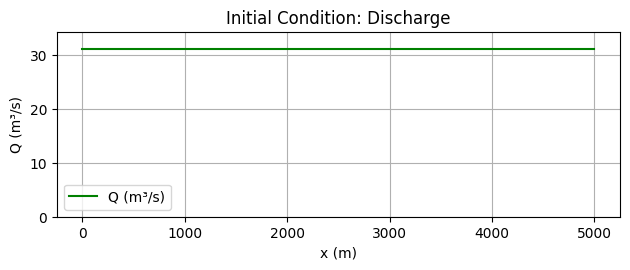

Plotting boundary condition: Type=gaussian, Qmax=300, tmax=5400.0, gamfac=5e-07
Q Values at boundary: [31.20818385 31.20822047 31.20826626 31.20832343 31.20839466 31.20848323
 31.20859316 31.20872932 31.20889766 31.20910536] ...


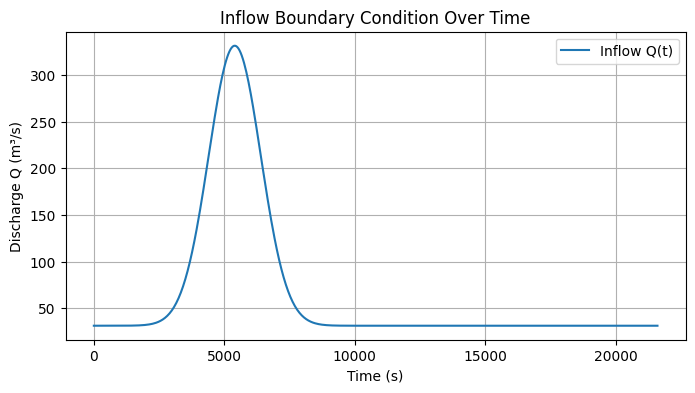

In [5]:
T_final = 3600 * 6  # 5 hours

# Create a river with custom parameters
river = River(
    Lx=5000.0,
    Nx=2500,
    w0=100.0,
    w1=90.0,
    w2=80.0,
    slope=-0.001,
    Cm=0.1,
    profile_type=0
)

# Create solver
solver = RiverSolver(
    river=river,
    H0=1.0,
    CFL=0.5,
    Qmax=300,  # Set to nonzero for time-varying inflow
    tmax=T_final / 4,
    boundaryType="gaussian",
    gamfac=0.0000005, # To get a 3 hour peak
)

solverCFL1 = RiverSolver(
    river=river,
    H0=1.0,
    CFL=1.0,
    Qmax=300,  # Set to nonzero for time-varying inflow
    tmax=T_final / 4,
    boundaryType="gaussian",
    gamfac=0.0000005, # To get a 3 hour peak    
)
solverCFL025 = RiverSolver(
    river=river,
    H0=1.0,
    CFL=0.25,
    Qmax=300,  # Set to nonzero for time-varying inflow 
    tmax=T_final / 4,
    boundaryType="gaussian",
    gamfac=0.0000005, # To get a 3 hour peak
)

# Set initial condition
solver.set_initial_condition()
solver.plot_ic()

solverCFL1.set_initial_condition()
solverCFL025.set_initial_condition()


solver.plot_boundary_condition()


In [6]:
times, solutions = solver.solve(T_final, n_output=16)
timesCFL1, solutionsCFL1 = solverCFL1.solve(T_final, n_output=16)
timesCFL025, solutionsCFL025 = solverCFL025.solve(T_final, n_output=16)

Starting solver: T_final=21600s, dt=0.3192754284070505s, n_steps≈67653
  t = 0.3s (step 1)
  t = 1350.2s (step 4229)
  t = 2700.1s (step 8457)
  t = 4050.0s (step 12685)
  t = 5400.2s (step 16914)
  t = 6750.1s (step 21142)
  t = 8100.0s (step 25370)
  t = 9450.2s (step 29599)
  t = 10800.1s (step 33827)
  t = 12150.0s (step 38055)
  t = 13500.2s (step 42284)
  t = 14850.1s (step 46512)
  t = 16200.0s (step 50740)
  t = 17550.3s (step 54969)
  t = 18900.1s (step 59197)
  t = 20250.0s (step 63425)
  t = 21600.3s (step 67654)
Solver completed: 67654 steps in 2.91 minutes
Starting solver: T_final=21600s, dt=0.638550856814101s, n_steps≈33826
  t = 0.6s (step 1)
  t = 1350.5s (step 2115)
  t = 2700.4s (step 4229)
  t = 4050.3s (step 6343)
  t = 5400.2s (step 8457)
  t = 6750.1s (step 10571)
  t = 8100.0s (step 12685)
  t = 9450.6s (step 14800)
  t = 10800.4s (step 16914)
  t = 12150.3s (step 19028)
  t = 13500.2s (step 21142)
  t = 14850.1s (step 23256)
  t = 16200.0s (step 25370)
  t = 175

In [7]:
# Solve


# Post-processing
xvals = np.linspace(0, river.Lx, 100)
widths = river.evaluate_width_array(xvals)


# Plot final solution
def plot_solution(solutions, xvals, widths, axes):
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    A_final = solutions[-1]
    areas = solver.evaluate_solution_array(xvals, A_final)
    depths = areas / widths
    Q_final = solver.compute_discharge(A_final)
    discharges = np.array([Q_final.at(x) for x in xvals])

    axes[0].plot(xvals, depths)
    axes[0].set_ylabel('Depth h (m)')
    axes[0].grid(True)

    axes[1].plot(xvals, widths)
    axes[1].set_ylabel('Width w (m)')
    axes[1].grid(True)

    axes[2].plot(xvals, discharges)
    axes[2].set_xlabel('Position s (m)')
    axes[2].set_ylabel('Discharge Q (m³/s)')
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig('class_based_solution.png')
    plt.show()

plot_solution(solutions, xvals, widths, axes)

/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


NameError: name 'axes' is not defined

/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


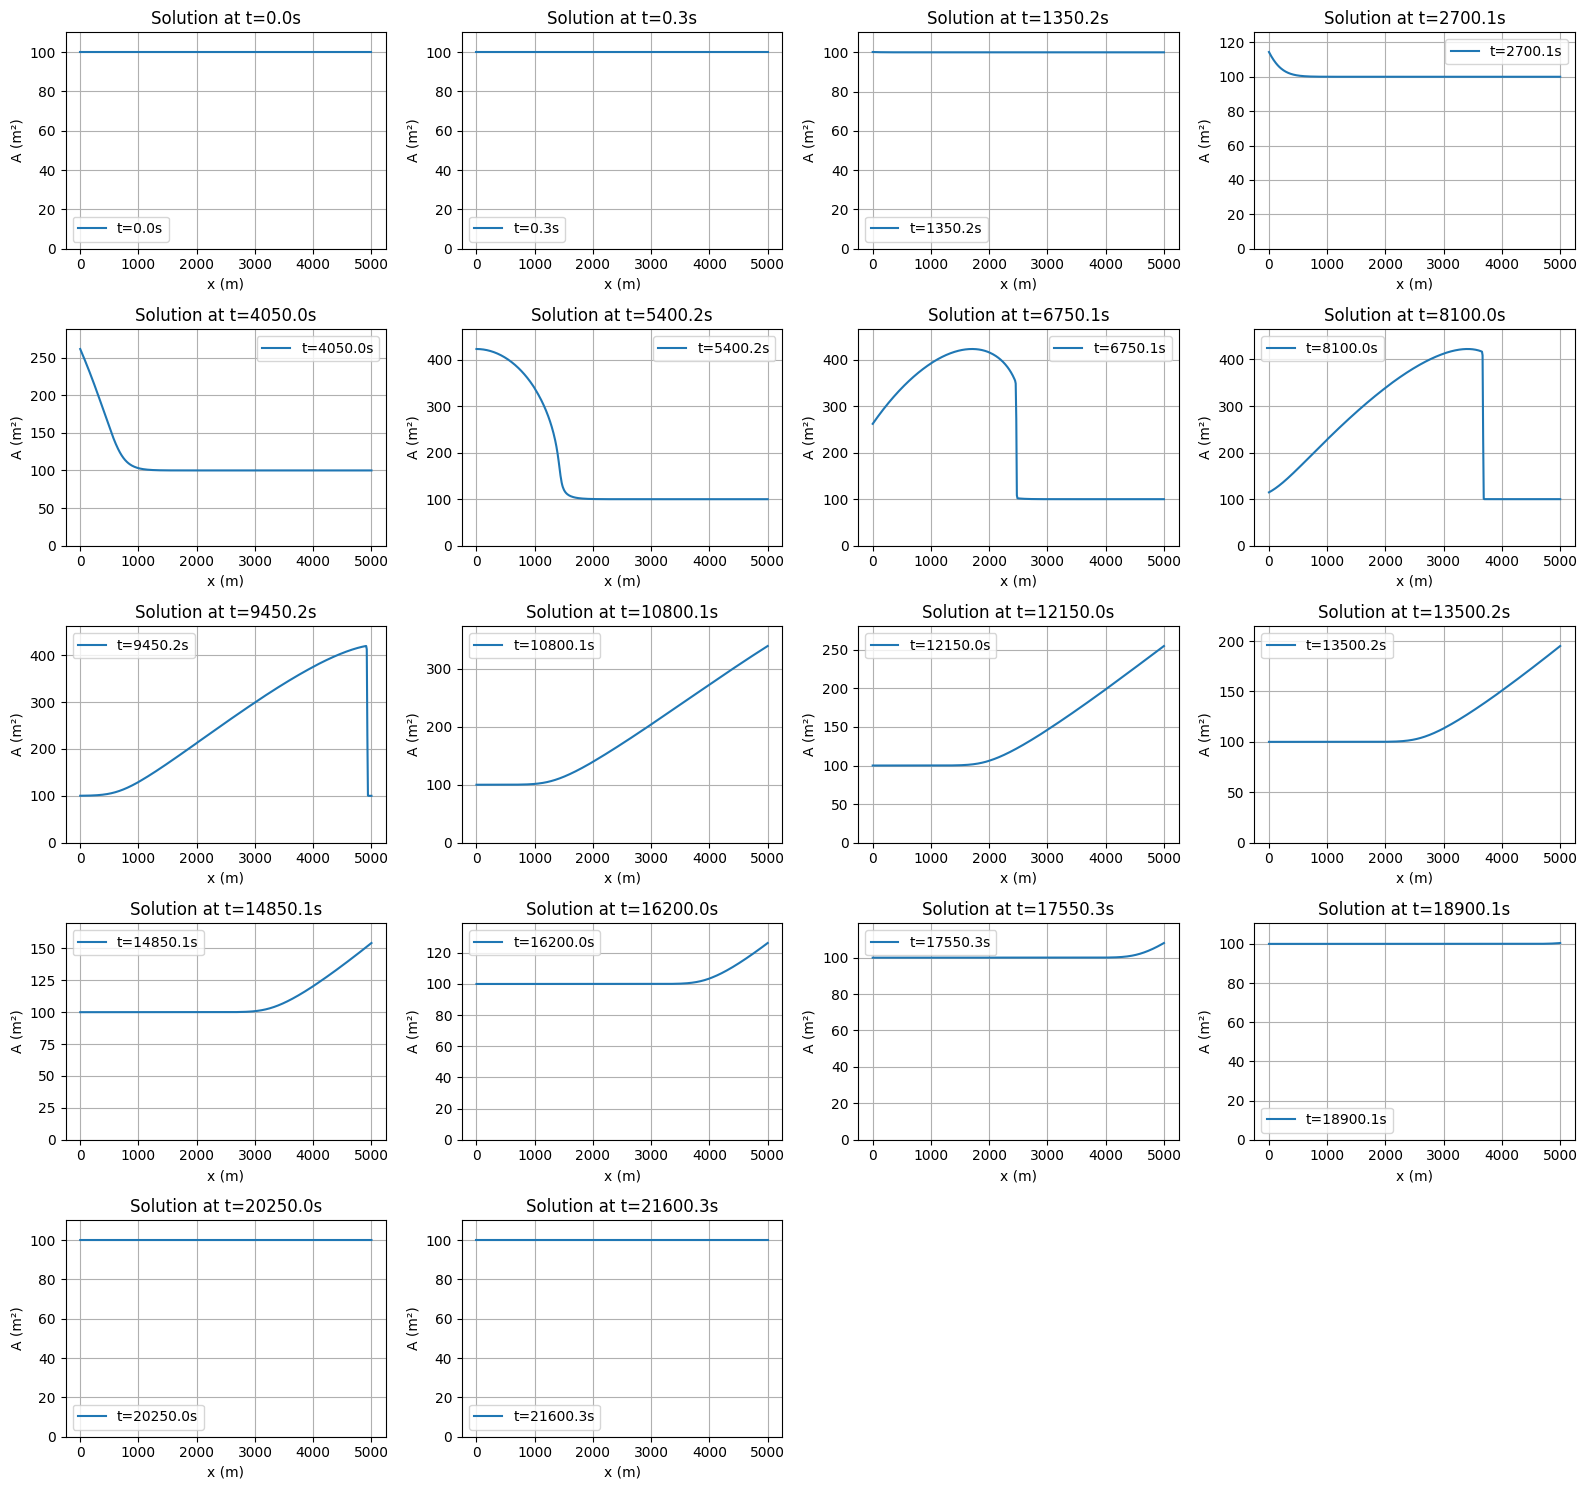

In [ ]:
solver.plot_solution_history()

/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


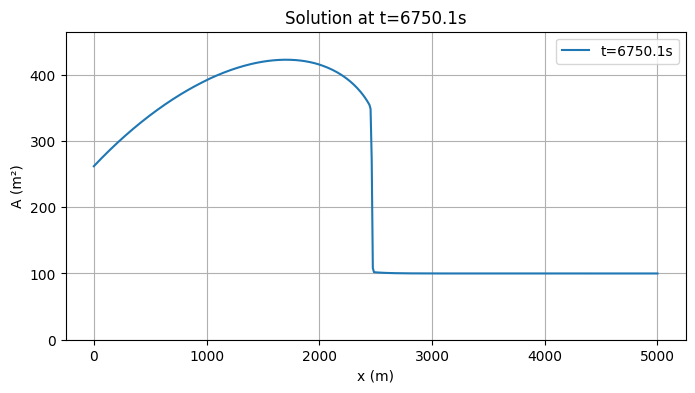

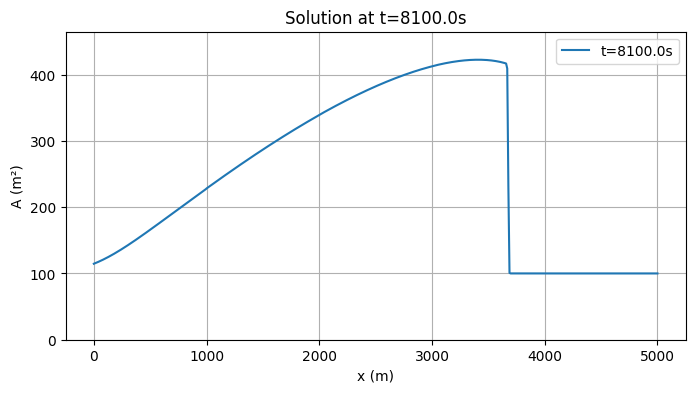

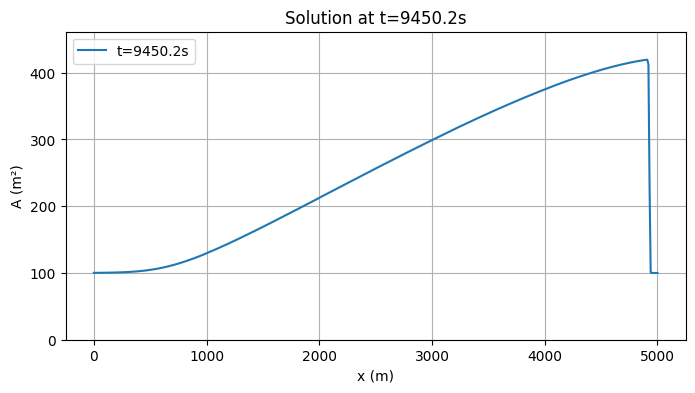

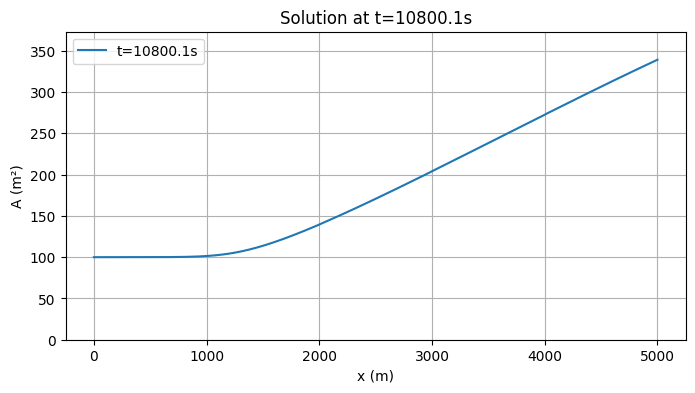

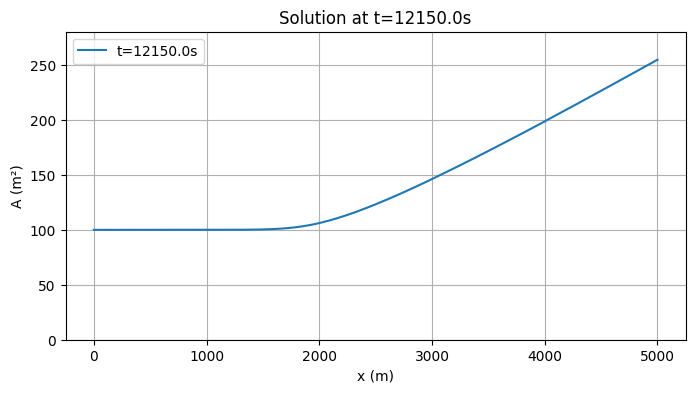

In [ ]:
solver.plot_at_time(6)
solver.plot_at_time(7)
solver.plot_at_time(8)
solver.plot_at_time(9)
solver.plot_at_time(10)